In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
mnist= keras.datasets.mnist
(x_train, y_train) , (x_test,y_test)= mnist.load_data()

# set the range 0-1
x_train, x_test= x_train/255.0, x_test/255.0


#reshape data in -1/28/28/1 shape
x_train, x_test= x_train.reshape(-1, 28,28,1), x_test.reshape(-1,28,28,1)

In [ ]:
#building the model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3),activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=9, validation_data=(x_test, y_test))


Epoch 1/9
1875/1875 [==============================] - 82s 43ms/step - loss: 0.1372 - accuracy: 0.9592 - val_loss: 0.0517 - val_accuracy: 0.9820
Epoch 2/9
1875/1875 [==============================] - 55s 30ms/step - loss: 0.0440 - accuracy: 0.9865 - val_loss: 0.0449 - val_accuracy: 0.9853
Epoch 3/9
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0308 - accuracy: 0.9904 - val_loss: 0.0360 - val_accuracy: 0.9886
Epoch 4/9
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0228 - accuracy: 0.9930 - val_loss: 0.0296 - val_accuracy: 0.9903
Epoch 5/9
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0175 - accuracy: 0.9944 - val_loss: 0.0375 - val_accuracy: 0.9884
Epoch 6/9
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0137 - accuracy: 0.9955 - val_loss: 0.0285 - val_accuracy: 0.9912
Epoch 7/9
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0104 - accuracy: 0.9966 - val_loss: 0.0292 - val_ac

313/313 [==============================] - 4s 12ms/step - loss: 0.0411 - accuracy: 0.9905

Test accuracy: 0.9904999732971191
313/313 [==============================] - 3s 8ms/step

Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



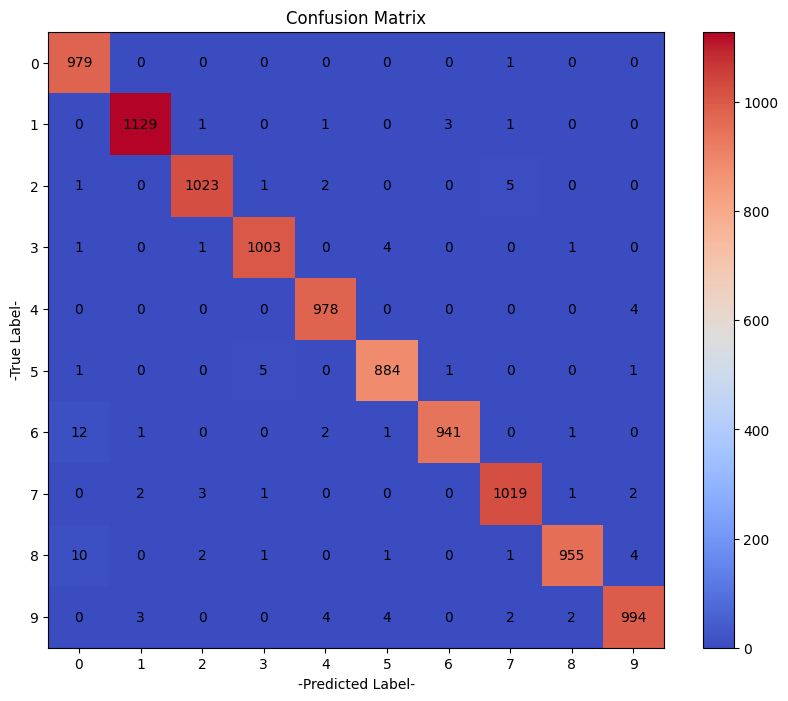

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

#Predict on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)


# Classification report
print('\nReport:')
print(classification_report(y_test, y_pred_classes))


#Confusion Martix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='coolwarm', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()

# Add the numbers inside the matrix cells
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), ha='center', va='center', color='black')

#  Set_axis labels
plt.xlabel('-Predicted Label-')
plt.ylabel('-True Label-')
plt.xticks(np.arange(10),labels=np.arange(10))
plt.yticks(np.arange(10),labels=np.arange(10))
plt.show()




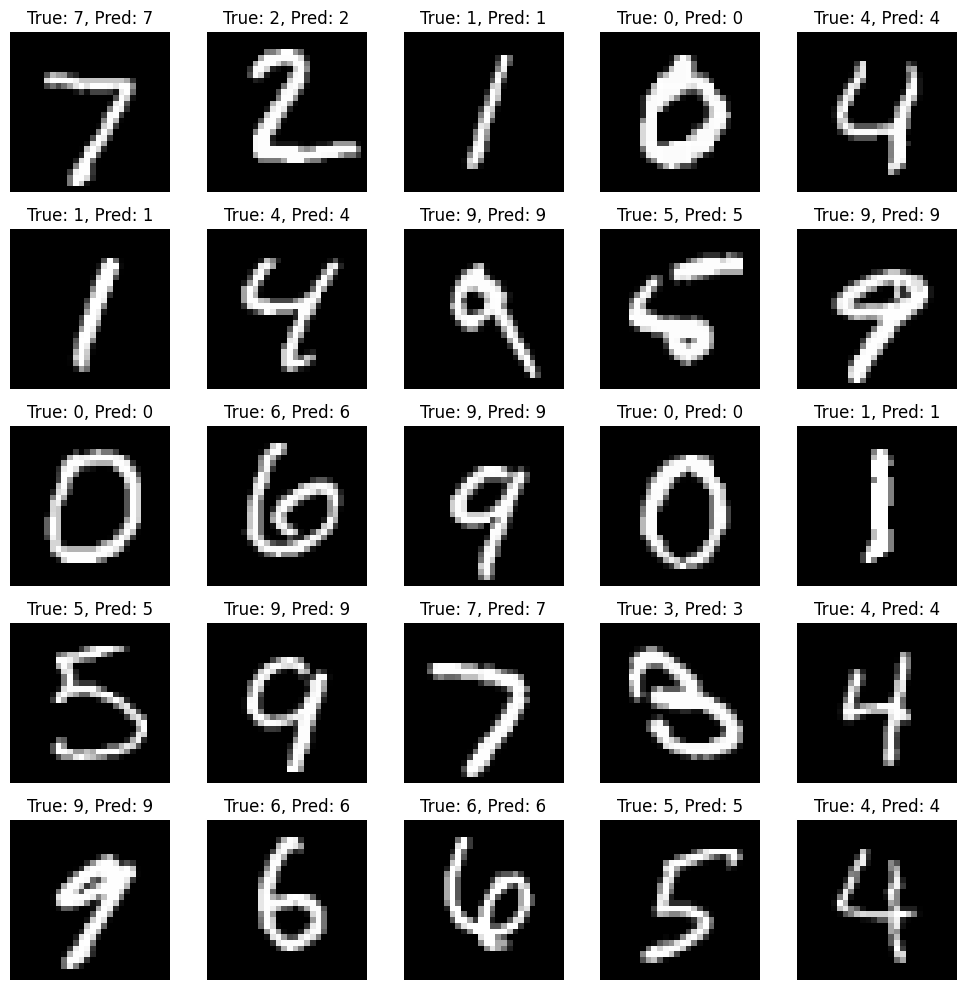

In [ ]:
# Now i wnt to display some test images with their predictions, to understand the behavior of the model
num_rows, num_cols = 5, 5
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_rows*num_cols):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_test[i]}, Pred: {y_pred_classes[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
'''Let's create a function to classify the preprocessed image using the trained model
 and add logic to handle images that might not belong to any known class by setting a confidence threshold'''
def classify_image(image_path, model, threshold):
    img = preprocess_image(image_path)
    pred = model.predict(img)
    confidence = np.max(pred)

    if confidence < threshold:
        return "Unrecognizable"
    else:
        return np.argmax(pred, axis=1)[0]


#preprocessing method
from PIL import Image


def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize((28, 28))  # Resize to 28x28
    img = np.array(img) / 255.0  # Normalize
    img = img.reshape(-1, 28, 28, 1)  # Reshape
    return img





In [ ]:
#let's import a new image
from google.colab import files
uploaded = files.upload()


Saving 3.png to 3 (1).png


In [ ]:
result = classify_image("3.png", model, threshold=0.99)
print('Classification result:', result)

1/1 [==============================] - 0s 22ms/step
Classification result: Unrecognizable


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    #  model that outputs the final conv layer's feature maps and the final model's predictions(the classification)
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        # Forward pass
        conv_outputs, predictions = grad_model(img_array)

        if pred_index is None:
            # usually this model predict itself the final output
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute the gradient of the class score with respect to the feature maps
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Weight the feature maps by the gradients
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Apply ReLU
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()  #tensor to numpy array


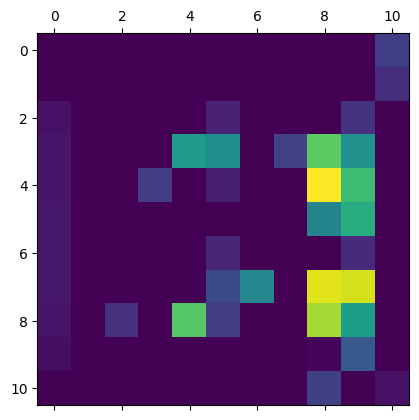

In [ ]:
# Load the image
image_path = '3.png'
img_array = preprocess_image(image_path)

# Generate the heatmap
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_5')  # 'conv2d_1' is the name of the second Conv2D layer

# Display the heatmap
plt.matshow(heatmap)
plt.show()
